## `Detect by YOLO`

In [1]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Cfg.load_config_from_name("vgg_seq2seq")
config["cnn"]["pretrained"] = True
config["predictor"]["beamsearch"] = True
config["device"] = "cpu"
detector = YOLO("My_weight/model_28_10.pt")
recognitor = Predictor(config)

Model weight C:\Users\ADMIN\AppData\Local\Temp\vgg_seq2seq.pth exsits. Ignore download!


In [3]:
class_colors = {
    "current_places": (255,0,0),
    "dob": (0,255,0),
    "expire_date": (0,0,255),
    "gender": (255,255,0),
    "id": (255,0,255),
    "name":(0,255,255),
    "nationality": (255, 128, 0),
    "origin_place": (0,0,0)
}

In [4]:
def predict(recognitor, detector, input_path, padding = 2, dpi=100):
    img = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
    detect = detector(img)
    class_indexes = detect[0].boxes.cls.numpy()
    class_names = [detector.names[int(class_index)] for class_index in class_indexes]
    boxes = detect[0].boxes.xyxy.numpy()
    
    result_dict = {name: [] for name in detector.names.values()}
    for i, box in enumerate(boxes):
        box[0] = box[0] - padding
        box[1] = box[1] - padding
        box[2] = box[2] + padding
        box[3] = box[3] + padding   
        x1, y1, x2, y2 = box
        crop_img = img[int(y1):int(y2), int(x1):int(x2)]
        crop_img_rgb = Image.fromarray(crop_img)
        color = class_colors.get(class_names[i], (255,255,255))
        text = recognitor.predict(crop_img_rgb)
        img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color = color, thickness=2)
        result_dict[class_names[i]].append(text)
        
    order_texts = [
        ', '.join(result_dict[detector.names[i]]) for i in sorted(detector.names)
    ]
    
    plt.figure(figsize=(6,6), dpi=dpi)
    plt.imshow(img)
    print(f"result are: {order_texts}")
    return boxes, order_texts


0: 640x640 2 current_places, 1 dob, 1 expire_date, 1 gender, 1 id, 1 name, 1 nationality, 1 origin_place, 317.9ms
Speed: 33.2ms preprocess, 317.9ms inference, 42.7ms postprocess per image at shape (1, 3, 640, 640)
result are: ['334 Điện Biên, Phủ, Chính Gián, Thanh Khê, Đà Năng', '19/09/2003', '19/09/2028', 'Nam', '048203000697', '', 'TRẦN VĂN THANH DUY', 'Việt Nam', 'Duy Xuyên, Quảng Nam']


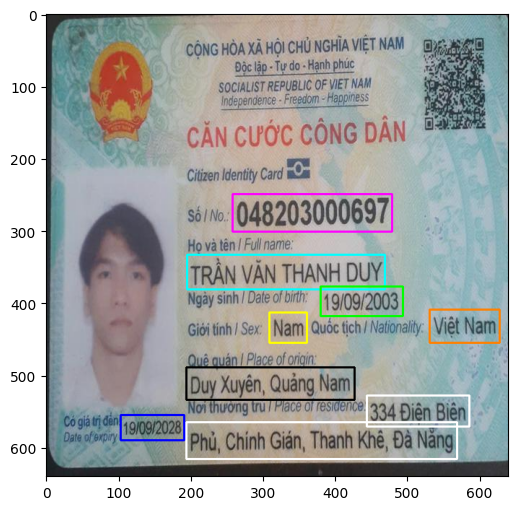

In [5]:
input_path = "cccd_640.jpg"
boxes, texts = predict(recognitor, detector, input_path, padding=2, dpi= 100)


0: 416x640 1 current_place, 1 dob, 1 expire_date, 1 gender, 1 id, 1 name, 1 nationality, 1 origin_place, 194.5ms
Speed: 10.4ms preprocess, 194.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)
result are: ['Chính Gián, Thanh Khê, Đà Nắng', '31/01/2006', '31/01/2031', 'Nam', '048206001981', '', 'TRẦN VĂN THANH LÂM', 'Việt Nam', 'Duy Xuyên, Quảng Nam']


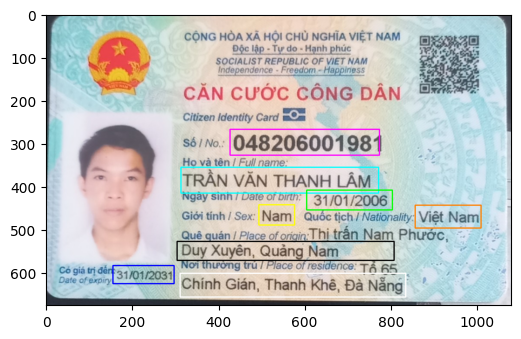

In [6]:
input_path = "ramu.jpg"
boxes, texts = predict(recognitor, detector, input_path, padding=2, dpi= 100)


0: 640x640 2 current_places, 1 dob, 1 expire_date, 1 gender, 1 id, 1 name, 1 nationality, 1 origin_place, 179.3ms
Speed: 5.2ms preprocess, 179.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)
result are: ['Tây Yên A, An Biên, Kiên Giang, Ấp Rọc Lá', '01/01/1987', '01/01/2027', 'Nữ', '093187008605', '', 'BÙI THỦY AN', 'Việt Nam', 'Long Mỹ, Hậu Giang']


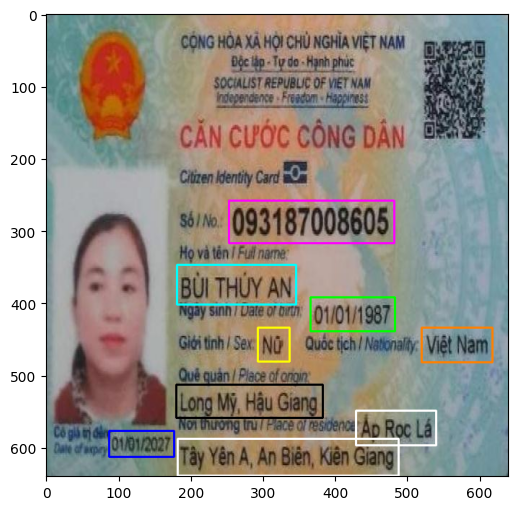

In [7]:
input_path = "imagess/image45.jpg"
boxes, texts = predict(recognitor, detector, input_path, padding=2, dpi= 100)

## `My model`

In [8]:
config = Cfg.load_config_from_name('vgg_seq2seq')
config["weights"] = "My_weight/seq1seq.pth" # File'size is too big to upload into Github
config['cnn']['pretrained'] = False
config['device'] = 'cpu'
 
recognitor2 = Predictor(config)


0: 640x640 2 current_places, 1 dob, 1 expire_date, 1 gender, 1 id, 1 name, 1 nationality, 1 origin_place, 168.1ms
Speed: 11.8ms preprocess, 168.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
result are: ['334 Điện Biên, Phủ, Chính Gián, Thanh Khê, Đà Nẵng', '19/09/2003', '19/09/2028', 'Nam', '048203000697', '', 'TRẦN VĂN THANH DUY', 'Việt Nam', 'Duy Xuyên, Quảng Nam']


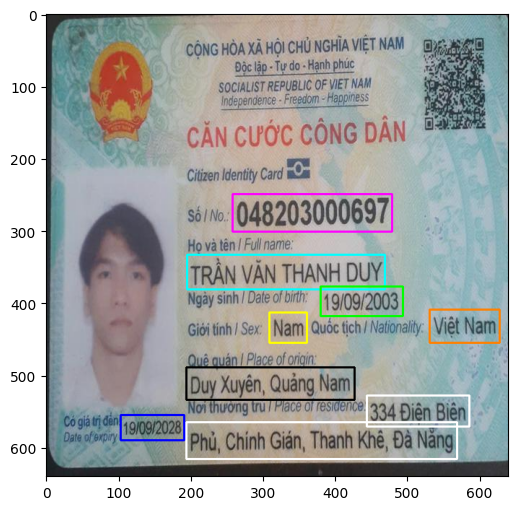

In [9]:
input_path = "cccd_640.jpg"
boxes, texts = predict(recognitor2, detector, input_path, padding=2, dpi= 100)

0: 640x640 2 current_places, 1 dob, 1 expire_date, 1 gender, 1 id, 1 name, 1 nationality, 1 origin_place, 186.3ms
Speed: 7.6ms preprocess, 186.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
result are: ['Tây Yên A, An Biên, Kiên Giang, Cẩp Rọc Lá', '01/01/1987', '01/01/2027', 'Nữ', '093187008605', '', 'BÙI THỦY AN', 'Việt Nam', 'Long Mỹ, Hậu Giang']


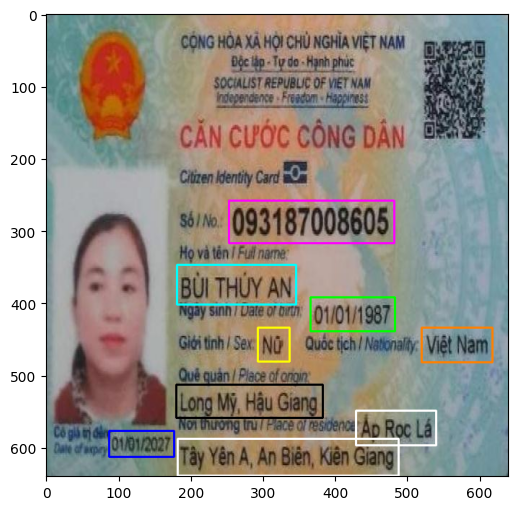

In [10]:
input_path = "imagess/image45.jpg"
boxes, texts = predict(recognitor2, detector, input_path, padding=2, dpi= 100)